# Misc Notes for package histology (using melanoma dataset)

For detailed analyses on the melanoma dataset, please check the [./melanoma.ipynb] file.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata as ann

import spatialdm as sdm
from spatialdm.datasets import dataset
import spatialdm.plottings as pl

import matplotlib.pyplot as plt
print("SpatailDM version: %s" %sdm.__version__)

SpatailDM version: 0.2.0


In [2]:
adata = dataset.melanoma()
sdm.weight_matrix(adata, l=1.2, cutoff=0.2, single_cell=False)
sdm.extract_lr(adata, 'human', min_cell=3)

In [3]:
import time
start = time.time()

# global Moran selection
sdm.spatialdm_global(adata, method='z-score', nproc=1)

# select significant pairs
sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)

print("%.3f seconds" %(time.time()-start))

10.756 seconds


In [4]:
start = time.time()
# local spot selection
sdm.spatialdm_local(adata, method='z-score', nproc=1)

# significant local spots
sdm.sig_spots(adata, method='z-score', fdr=False, threshold=0.1)

print("%.3f seconds" %(time.time()-start))

1.764 seconds


### alternative DE input with Moran R values

In [5]:
# local_sum = adata.uns['selected_spots'].copy()
# local_sum=local_sum.transpose()
# local_sum[local_sum.columns] =(adata.uns['local_stat']['local_I'] + adata.uns['local_stat']['local_I'])

# results = SpatialDE.run(adata.obsm['spatial'], local_sum)

# histologyesults, patterns = SpatialDE.aeh.spatial_patterns(adata.obsm['spatial'], local_sum,
#                                                              results, C=3, l=5,
#                                                              verbosity=1)
# plt.figure(figsize=(9,8))
# for i in range(3):
#     plt.subplot(2, 2, i + 1)
#     plt.scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1], marker = 's',c=patterns[i], s=35);
#     plt.axis('equal')
#     pl.plt_util('Pattern {} - {} genes'.format(i, histologyesults.query('pattern == @i').shape[0] ))

## Cell type prediction with local Moran

Interestingly, the interaction profile of each cell actually may have good concordence to the cell type identity. To varify this, we used the ligand-receptor interaction profile to predict the cell type label that was annotated from the original study.

In [6]:
from sklearn.linear_model import LinearRegression

<div class="alert alert-info">

**Note**    
The prediction results may differ by different annotation accuracy and potentially other factor. Here we generated the cell type decomposition results using RCTD.
</div>

Text(0.5, 1.0, 'linear regression prediction')

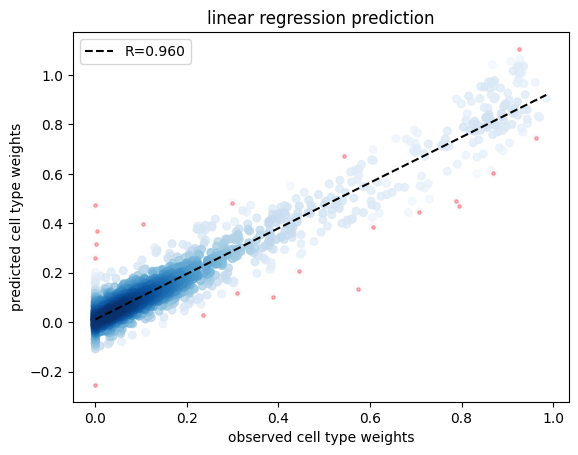

In [7]:
X = adata.uns['local_z_p'].values
y=adata.obs.values

reg = LinearRegression().fit(X.T, y)
y_pred = reg.predict(X.T)
pl.corr_plot(np.hstack(y),np.hstack(y_pred), method='pearson')
plt.xlabel('observed cell type weights')
plt.ylabel('predicted cell type weights')
plt.title('linear regression prediction')
# plt.savefig('linear_regression_celltype.pdf')

## Consistency between permutation and z-score approaches

In our work, we implemented two methods for hypothesis testing, `method='permutation'` or `method='z-score'` or `method='both'`.

For the z-score method, we derived the first and second moments of the null distribution to analytically obtain a z-score and its according p-values, which are highly consistent with the permutation method.
Here, we run both and compare the consistency.

In [8]:
sdm.spatialdm_global(adata, 1000, specified_ind=None, method='both', nproc=1)     # global Moran selection
sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)     # select significant pairs

100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 121.94it/s]


In [9]:
sdm.spatialdm_local(adata, n_perm=1000, method='both', specified_ind=None, nproc=1)     # local spot selection

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 501.43it/s]


/ssd/users/yuanhua/envs/TFProb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Global p-value correlation (Permutation vs. z-score)')

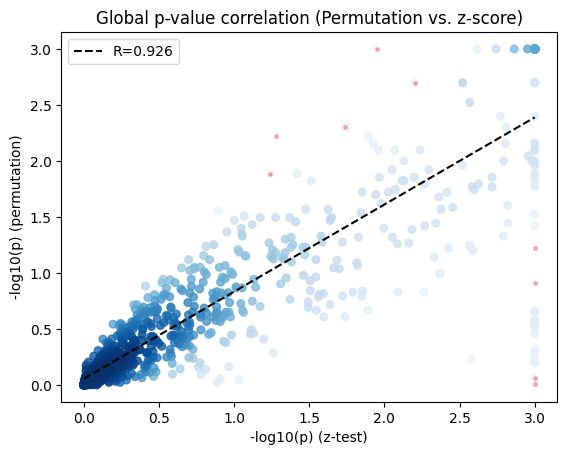

In [10]:
# global consistency
x = -np.log10(adata.uns['global_res'].z_pval.values)
y = -np.log10(adata.uns['global_res'].perm_pval)
 
x = np.where(x>3, 3, x)
y = np.where(np.isinf(y), 3, y)
pl.corr_plot(x, y, method='spearman')
plt.xlabel('-log10(p) (z-test)')
plt.ylabel('-log10(p) (permutation)')
plt.title('Global p-value correlation (Permutation vs. z-score)')
# plt.savefig('mel_perm_z_corr.pdf')

Text(0.5, 1.0, 'Correlation of number of selected \nlocal spots (Permutation vs. z-score)')

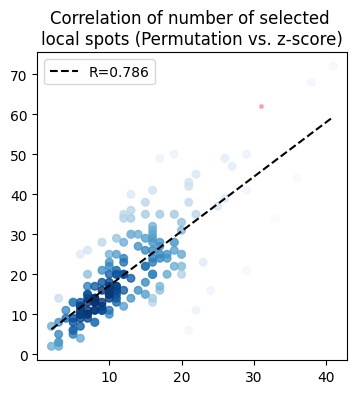

In [11]:
# local consistency
plt.figure(figsize=(4,4))
x=(adata.uns['local_z_p']<0.1).sum(1).values
y=(adata.uns['local_perm_p']<0.1).sum(1).values
pl.corr_plot(x, y, method='pearson')
plt.title('Correlation of number of selected \nlocal spots (Permutation vs. z-score)')
# plt.savefig('mel_local_cor.pdf')

## Deprecation Note: Spatial Clustering using SpatialDE

We have now employed SparseAEH instead of the original method SpatialDE for faster calculation of high-dimensional data.

(Also, SpatialDE is not compatible with scipy>1.11.4)
```bash
# install scipy<=1.11.4 for use SpatialDE
!pip install scipy==1.11.4
```

Commented codes as a reference:
```python
import NaiveDE
import SpatialDE

# SpatialDE code
bin_spots = adata.uns['selected_spots'].astype(int)[adata.uns['local_stat']['n_spots']>2]
print(bin_spots.shape[0], " pairs used for spatial clustering")

from threadpoolctl import threadpool_limits

with threadpool_limits(limits=1, user_api='blas'):
    results = SpatialDE.run(adata.obsm['spatial'], 
                            bin_spots.transpose())
    
    histology_results, patterns = SpatialDE.aeh.spatial_patterns(
        adata.obsm['spatial'], bin_spots.transpose(), 
        results, C=3, l=3, verbosity=1)
    
plt.figure(figsize=(9,8))
for i in range(3):
    plt.subplot(2, 2, i + 2)
    plt.scatter(adata.obsm['spatial'][:,0], adata.obsm['spatial'][:,1], 
                marker = 's',c=patterns[i], s=35);
    plt.axis('equal')
    pl.plt_util('Pattern {} - {} genes'.format(
        i, histology_results.query('pattern == @i').shape[0] ))
plt.savefig('mel_DE_clusters.pdf')
```